# Прогнозирование подходящих тарифов

Предоставлены данные о поведении клиентов, которые уже перешли на тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф.

Необходимо построить модель с максимально большим значением *accuracy*. (нужно довести долю правильных ответов до 0.75)

## Просмотр данных

In [1]:
# импорт необходимых библиотек
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier

In [2]:
# чтение и просмотр файла
df = pd.read_csv('/datasets/users_behavior.csv')
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


**Вывод:**
- В данных отстутствуют пропуски.
- Целевой признак имеет категориальную форму.
- Данные относятся к типам `float` и `int`.

## Разбиение данных на выборки

In [4]:
# определение целевого признака и признаков
features = df.drop(['is_ultra'], axis = 1)
target = df['is_ultra']

In [5]:
# деление исходного набора данных на две выборки: обучающую и тестовую
# под обучающую отвела 60%, под тестовую - 40%, чтобы в дальнейшем разбить 
# её на тестовую и валидационную
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size = 0.4, random_state = 12345,
                                                                            stratify=target)

In [6]:
# деление тестовой выборки на тестовую и валидационную
# от исходного набора данных они содержат каждая по 20%
features_test, features_valid, target_test, target_valid = train_test_split(features_test, target_test, 
                                                                            test_size = 0.5, random_state = 12345,
                                                                            stratify=target_test)

In [7]:
# проверка корректности разбиения
print(features_train.shape,
      features_test.shape, 
      features_valid.shape)

(1928, 4) (643, 4) (643, 4)


**Вывод:**
- Определены целевой признак и признаки.
- Данные разделены на три выборки: обучающую, тестовую и валидационную. 
- Сделана проверка корректности разбиения.

## Исследование моделей

### Исследование качества решающего дерева

In [9]:
# изменение гиперпараметра max_depth
# выявление лучшего значения метрики
best_model = None
best_result = 0
best_depth = 0
for depth in range(1,11):
    model = DecisionTreeClassifier(random_state = 12345, max_depth = depth)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions_valid)
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth
print('Лучшее значение accuracy:', best_result, 
      'Глубина дерева:', best_depth)
#print('max_depth =', depth, ": ", end='')
#print(accuracy_score(target_valid, predictions_valid))

Лучшее значение accuracy: 0.8118195956454122 Глубина дерева: 5


**Вывод:**
- Из рассматриваемых вариантов значений гиперпараметра `max_depth` лучшее качество показывает дерево с глубиной равной 5. 

Лучшее значение accuracy: 0.8118195956454122 Глубина дерева: 5


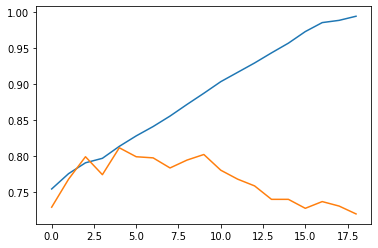

In [10]:
# код ревьюера

# изменение гиперпараметра max_depth
# выявление лучшего значения метрики
best_model = None
best_result = 0
best_depth = 0

# добавил
lst_test = []
lst_train = []
# добавил

for depth in range(1,20):
    model = DecisionTreeClassifier(random_state = 12345, max_depth = depth)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions_valid)
# добавил    
    predictions_train = model.predict(features_train)
    result_train = accuracy_score(target_train, predictions_train)
    lst_train.append(result_train)
    lst_test.append(result)
# добавил


    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth
print('Лучшее значение accuracy:', best_result, 
      'Глубина дерева:', best_depth)
#print('max_depth =', depth, ": ", end='')
#print(accuracy_score(target_valid, predictions_valid))


# добавил
import matplotlib.pyplot as plt
plt.plot(lst_train)
plt.plot(lst_test)
plt.show()

# и видим на графике как на train точность растет до 100%, а на валидации падает - переобучение.

### Исследование качества модели случайный лес

In [11]:
# объединим тренировочную и валидационную выборки 
features_tv = pd.concat([features_train]+[features_valid])
target_tv = pd.concat([target_train]+[target_valid])

In [12]:
model = RandomForestClassifier(random_state=12345)
parametrs = { 
    'n_estimators': range (10, 51, 10),
    'max_depth': range (1,11)
}
grid = GridSearchCV(model, parametrs, cv=5)
grid.fit(features_tv, target_tv)
grid.best_params_, grid.best_score_

({'max_depth': 9, 'n_estimators': 10}, 0.8031899059347966)

In [13]:
best_model = None
best_result = 0
best_est = 0
best_depth = 0 
for est in range(10,51,10):
    for depth in range(1,11):
        model = RandomForestClassifier(random_state = 12345, n_estimators = est, max_depth = depth)
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        result = accuracy_score(target_valid, predictions_valid)
        if result > best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth
print('Лучшее значение accuracy:', best_result, 
      'Количество деревьев:', best_est,
      'Глубина дерева:', best_depth)
   
#print('n_estimators =', est, ": ", end='')
#print(accuracy_score(target_valid, predictions_valid))

Лучшее значение accuracy: 0.8211508553654744 Количество деревьев: 20 Глубина дерева: 6


**Вывод:**
- Из рассматриваемых вариантов значений гиперпараметра `n_estimators` лучшее качество показывает значение равное 6, глубина дерева - 20.

### Исследование качества логистической регрессии

In [14]:
model = LogisticRegression(random_state = 12345, solver = 'lbfgs')
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
accuracy_score(target_valid, predictions_valid)

0.7465007776049767

**Вывод:**
- Лучшее качество предоставляет модель случайный лес.

## Проверка модели на тестовой выборке

In [15]:
predictions_test = best_model.predict(features_test)
accuracy_score(target_test, predictions_test)

0.8009331259720062

**Вывод:**
- Показатель accuracy > 0.74

In [18]:
# обучим модель на тренировочной + валидационной выборке
# объединение выборок выше
best_model.fit(features_tv, target_tv)
predictions_test = best_model.predict(features_test)
accuracy_score(target_test, predictions_test)

0.8304821150855366

**Вывод:**

Модель обучена на тренировочной + валидационной выборке, результат метрики не изменился.

##  Проверка модели на адекватность

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64


<AxesSubplot:>

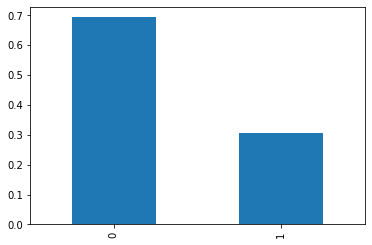

In [16]:
class_frequency = df['is_ultra'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

Тарифом Смарт пользовались чаще, чем тарифом Ультра.

In [17]:
dummy_clf = DummyClassifier(constant = '0')
dummy_clf.fit(features_train, target_train)
dummy_clf.predict(features_train)
dummy_clf.score(features_train, target_train)

0.6934647302904564

In [18]:
target_pred_constant = pd.Series([0]*len(target))
accuracy_score(target, target_pred_constant)

0.693528313627878

**Вывод:**

Можно считать, что модель является адекватной. Результат метрики обученной модели и константной примерно равны.

## Вывод

Построена модель случайный лес с лучшим значением исследуемой метрики - accuracy = 0.82.